In [1]:
from utils import *
from opt import *
import pandas as pd

(CVXPY) May 10 06:58:48 PM: Encountered unexpected exception importing solver CVXOPT:
ImportError('DLL load failed while importing base: No se puede encontrar el módulo especificado.')
(CVXPY) May 10 06:58:48 PM: Encountered unexpected exception importing solver GLPK:
ImportError('DLL load failed while importing base: No se puede encontrar el módulo especificado.')
(CVXPY) May 10 06:58:48 PM: Encountered unexpected exception importing solver GLPK_MI:
ImportError('DLL load failed while importing base: No se puede encontrar el módulo especificado.')


0
10
30
50
70
100


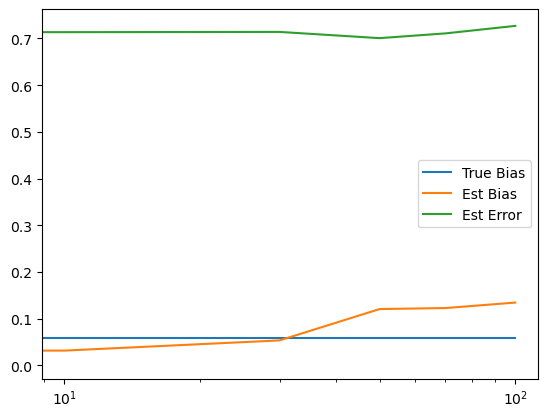

In [9]:
import scipy.io
mat = scipy.io.loadmat('real_data/facebook/facebook_data414.mat')
#mat = scipy.io.loadmat('real_data/school/school_data.mat')

A_true = np.array(mat['A_norm'])
A_true_bin = np.array(mat['A_bin'])
C_est = np.array(mat['C'])
C_est_norm = np.array(mat['C_norm'])
Z = np.array(mat['Z'])
X = np.array(mat['X'])
#z = np.array(mat['z'])


#print(C_est.shape)
#plt.imshow(C_est)
#plt.colorbar()

#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

C_hat = C_est
N = X.shape[0]
lamb = 1e-6
eta = 1e-2
betas = [0,10,30,50,70,100]
nb = len(betas)
bias_type = 'nodewise'
eval_bias_type = 'dp_scaled'
true_bias = np.zeros((nb,1))
est_bias = np.zeros((nb,1))
est_error = np.zeros((nb,1))

for i,beta in enumerate(betas):
    print(beta)
    A_aux = node_FGL_fista(C_hat, lamb, eta, beta, Z, bias_type, epsilon=.1, iters=1000, A_true=None)
    A_aux = A_aux/np.max(A_aux)
    true_bias[i] = compute_bias(A_true,Z,bias_type=eval_bias_type)
    est_bias[i] = compute_bias(A_aux,Z,bias_type=eval_bias_type)
    est_error[i] = compute_frob_error(A_aux,A_true)

fig = plt.figure()
ax = fig.subplots()
plt.semilogx(betas,true_bias,label='True Bias')
plt.semilogx(betas,est_bias,label='Est Bias')
plt.semilogx(betas,est_error,label='Est Error')

ax.legend()



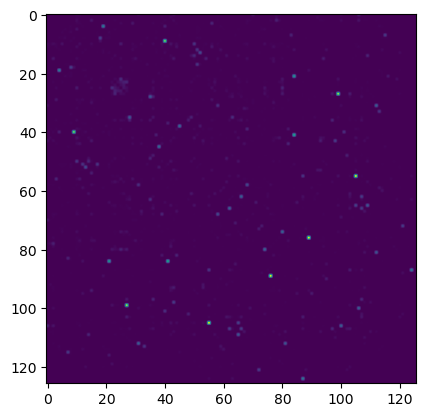

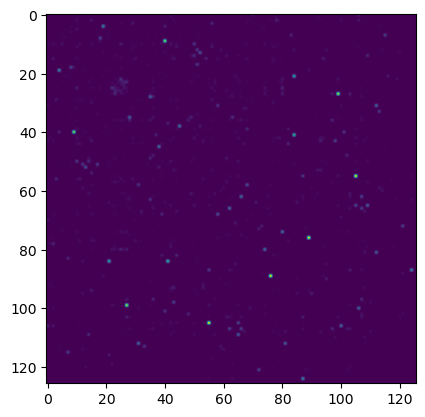

In [8]:
plt.figure()
plt.imshow(A_true)

plt.figure()
plt.imshow(A_aux)

In [ ]:
len(betas)



In [ ]:
# --------------------------------
verbose = True
num_trials = 20
num_range = 6

opt_bias_type = 'groupwise'
eval_bias_type = 'groupwise'
REWEIGHTED = False
UPPER_BOUND = False
norm_scale = lambda A: np.sum(A[0])

beta_range = np.logspace(-6,-1,num_range)
num_range = len(beta_range)
# --------------------------------


# --------------------------------
#X = np.array(votes_list).T
#z = nodes[0]
#G = len(np.unique(z))
#Z = np.eye(G)[z].T
N = X.shape[1]
M = X.shape[0]

#X = (X.T - np.mean(X, axis=1)) / np.std(X, axis=1);

#C_est = est_cov(X=X.T)
# --------------------------------


# --------------------------------
alpha = 1
beta = 100
delta = 1e-4
eps_thresh = 1e-2

lamb = 1e-6

gsr_args = {
    'C_hat':C_est,
    'Z':Z,
    'A_true':A_true,
    'lamb':lamb, #weight for the L1 norm
    'beta':0,  #weight for fairness
    'eta':0.01, #step size
    'bias_type': 'nodewise'
}
fista_args = {
    'C_hat':C_est,
    'Z':Z,
    'A_true':A_true,
    'lamb':lamb, #weight for the L1 norm
    'beta':beta,  #weight for fairness
    'eta':0.01, #step size
    'bias_type': 'nodewise'
}

mu = 1e2
eps_init = 1e-2
factor_eps = 1.5
max_iters_eps = 25
if UPPER_BOUND:
    gsr_args = gsr_args | {'eps':eps_init}
    fista_args = fista_args | {'eps':eps_init}

if REWEIGHTED:
    gsr_args = gsr_args | rw_args
    fista_args = fista_args | rw_args

EstGraph = node_FGL_fista
EstFGraph = node_FGL_fista
# --------------------------------


# --------------------------------
bias_nti = np.zeros(num_range)
bias_fnti = np.zeros(num_range)
# --------------------------------
error_nti = np.zeros(num_range)
error_fnti = np.zeros(num_range)
fsc_nti = np.zeros(num_range)
fsc_fnti = np.zeros(num_range)


# --------------------------------
for i,beta in enumerate(beta_range):
    if verbose:
        print(f'Beta: {beta:.4e}')
        fista_args['beta'] = beta



    A_nti  = EstGraph(**gsr_args)
    A_fnti = EstFGraph(**fista_args)
    if (A_nti is None) or (A_fnti is None):
        print(f'Problem did not converge. Proceed with caution.')
    
    
    
    A_norm_nti = A_nti/np.max(A_nti)
    A_norm_fnti = A_fnti/np.max(A_fnti)
    # --------------------------------


    # --------------------------------
    bias_nti[i] = compute_bias(A_norm_nti,Z,bias_type=eval_bias_type)
    bias_fnti[i] = compute_bias(A_norm_fnti,Z,bias_type=eval_bias_type)
    # --------------------------------
    
    error_nti[i] = compute_frob_error(A_norm_nti,A_true)
    error_fnti[i] = compute_frob_error(A_norm_fnti,A_true)
    fsc_nti[i] = compute_f1_score(A_norm_nti,A_true)
    fsc_fnti[i] = compute_f1_score(A_norm_fnti,A_true)

    
    
# --------------------------------


# --------------------------------
plt_args = {
    'linestyle':'-',
    'marker':'o',
    'markersize':7,
    'linewidth':2
}
# --------------------------------


# --------------------------------
# bias
fig = plt.figure(figsize=(6,4))
ax = fig.subplots()
ax.grid(True)
plt_args['c'] = reds[8]
ax.semilogx(beta_range, bias_nti, **plt_args, label='NTI')
plt_args['c'] = reds[14]
ax.semilogx(beta_range, bias_fnti, **plt_args, label='FNTI')

ax.set_xlabel('Fair penalty weight '+r'$\beta$')
ax.set_ylabel('Bias')
ax.legend()
fig.tight_layout()
# --------------------------------


# --------------------------------
# error
fig = plt.figure(figsize=(6,4))
ax = fig.subplots()
ax.grid(True)
plt_args['c'] = reds[8]
ax.semilogx(beta_range, error_nti, **plt_args, label='NTI')
plt_args['c'] = reds[14]
ax.semilogx(beta_range, error_fnti, **plt_args, label='FNTI')

ax.set_xlabel('Fair penalty weight '+r'$\beta$')
ax.set_ylabel('erorr')
ax.legend()
fig.tight_layout()
# --------------------------------

In [ ]:
plt.figure()
plt.imshow(A_norm_fnti)
plt.colorbar()

plt.figure()
plt.imshow(A_true_bin)
plt.colorbar()
#print(A_true_bin)

np.max(A_fnti)

In [ ]:
fista_args['beta'] = 1e-1
# --------------------------------
if UPPER_BOUND:
    gsr_args['eps'] = eps_init
    fista_args['eps'] = eps_init
    for i_eps in range(max_iters_eps):
        A_nti = EstGraph(**gsr_args)
        A_fnti = EstFGraph(**fista_args)
        if (A_nti is not None) and (A_fnti is not None):
            break
        gsr_args['eps'] *= factor_eps
        fista_args['eps'] *= factor_eps
else:
    A_nti = EstGraph(**gsr_args)
    A_fnti = EstFGraph(**fista_args)
if (A_nti is None) or (A_fnti is None):
    print(f'Problem did not converge. Proceed with caution.')
A_norm_nti = A_nti/norm_scale(A_nti) if norm_scale(A_nti) else np.zeros_like(A_nti)
A_norm_fnti = A_fnti/norm_scale(A_fnti) if norm_scale(A_fnti) else np.zeros_like(A_fnti)
# --------------------------------


np.fill_diagonal(A_fnti,0)
np.fill_diagonal(A_nti,0)
plt.imshow(A_fnti)
plt.colorbar()


In [ ]:
np.fill_diagonal(A_fnti,0)
np.fill_diagonal(A_nti,0)
plt.imshow(A_nti)
plt.colorbar()

In [ ]:
from matplotlib import colormaps
import networkx as nx

pos = nx.spring_layout(nx.Graph(A_nti))
party_colors = [blues[10],reds[10],yellows[6]]
party_edge_colors = [blues[18],reds[18],yellows[16]]
clr_list = [party_colors[Z[0,i]] for i in range(N)]
edge_list = [party_edge_colors[Z[0,i]] for i in range(N)]
cmap = colormaps['Greys']

eps_thresh = 0.001

A_nti_pred = np.abs(A_nti)
A_nti_pred[A_nti_pred <= eps_thresh] = 0
A_fnti_pred = np.abs(A_fnti)
A_fnti_pred[A_fnti_pred <= eps_thresh] = 0

# --------------------------------

plt.imshow(A_fnti_pred)
plt.colorbar()

In [ ]:
edge_color = [edgedata['weight'] for _, _, edgedata in nx.Graph(A_nti_pred).edges(data=True)]
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()
ax.axis('off')
nx.draw_networkx_edges(nx.Graph(A_nti_pred), 
                       alpha=.8,
                       pos=pos, width=1,
                       edge_color=edge_color,
                       edge_cmap=cmap, 
                       edge_vmin=A_nti_pred.max()*0, 
                       edge_vmax=A_nti_pred.max()*.3
                       )
nx.draw_networkx_nodes(nx.Graph(A_nti_pred), 
                       pos=pos, node_size=150, linewidths=1,
                       node_color=clr_list,
                       edgecolors=edge_list)


edge_color = [edgedata['weight'] for _, _, edgedata in nx.Graph(A_fnti_pred).edges(data=True)]
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()
ax.axis('off')
nx.draw_networkx_edges(nx.Graph(A_fnti_pred), 
                       alpha=.8,
                       pos=pos, width=1, 
                       edge_color=edge_color,
                       edge_cmap=cmap, 
                       edge_vmin=A_fnti_pred.max()*0, 
                       edge_vmax=A_fnti_pred.max()*.3
                       )
nx.draw_networkx_nodes(nx.Graph(A_fnti_pred), 
                       pos=pos, node_size=150, linewidths=1,
                       node_color=clr_list,
                       edgecolors=edge_list)
# --------------------------------